In [75]:
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import json

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
# Пути
BASE_DIR = './flowers'
MODEL_DIR = './models'
os.makedirs(MODEL_DIR, exist_ok=True)

# Параметры
TARGET_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 15
NUM_CLASSES = 5

# Классы цветов
flowers = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [63]:
# Функция сбора датасета
def prepare_dataset(base_dir, classes):
    image_paths = []
    labels = []

    for flower in classes:
        flower_dir = os.path.join(base_dir, flower)
        for fname in os.listdir(flower_dir):
            image_paths.append(os.path.join(flower_dir, fname))
            labels.append(flower)
    
    df = pd.DataFrame({'image_path': image_paths, 'label': labels})
    return df

# Загрузка и разделение данных
df = prepare_dataset(BASE_DIR, flowers)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

print(f"Размер тренировочного набора: {len(train_df)} изображений")
print(f"Размер тестового набора: {len(test_df)} изображений")

Размер тренировочного набора: 3021 изображений
Размер тестового набора: 1296 изображений


In [99]:
# Аугментация данных
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=45,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Генераторы данных
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3021 validated image filenames belonging to 5 classes.
Found 1296 validated image filenames belonging to 5 classes.


In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization

def create_model(input_shape=(150, 150, 3), num_classes=5):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        GlobalAveragePooling2D(),

        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = create_model(input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3), num_classes=NUM_CLASSES)

D:\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [103]:
# Компиляция модели
model.compile(
    optimizer=AdamW(learning_rate=0.0005, weight_decay=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [105]:
# Оценка модели до обучения
initial_loss, initial_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nДо обучения: loss = {initial_loss:.4f}, accuracy = {initial_accuracy:.4f}\n")

D:\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.1818 - loss: 1.6097

До обучения: loss = 1.6094, accuracy = 0.1883



In [107]:
# Обучение модели
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

D:\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.4394 - loss: 1.3855 - val_accuracy: 0.2569 - val_loss: 1.7289
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.5627 - loss: 1.1221 - val_accuracy: 0.2569 - val_loss: 2.1701
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.6016 - loss: 1.0008 - val_accuracy: 0.2608 - val_loss: 2.3078
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.6324 - loss: 0.9238 - val_accuracy: 0.2878 - val_loss: 1.5837
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.6646 - loss: 0.8707 - val_accuracy: 0.4151 - val_loss: 1.4057
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.6605 - loss: 0.8682 - val_accuracy: 0.5347 - val_loss: 1.1665
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.6769 - loss: 0.8114 - val_accuracy: 0.5255 - val_loss: 1.2247
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.7000 - loss: 0.7923 - val_accuracy: 0.6944 - v

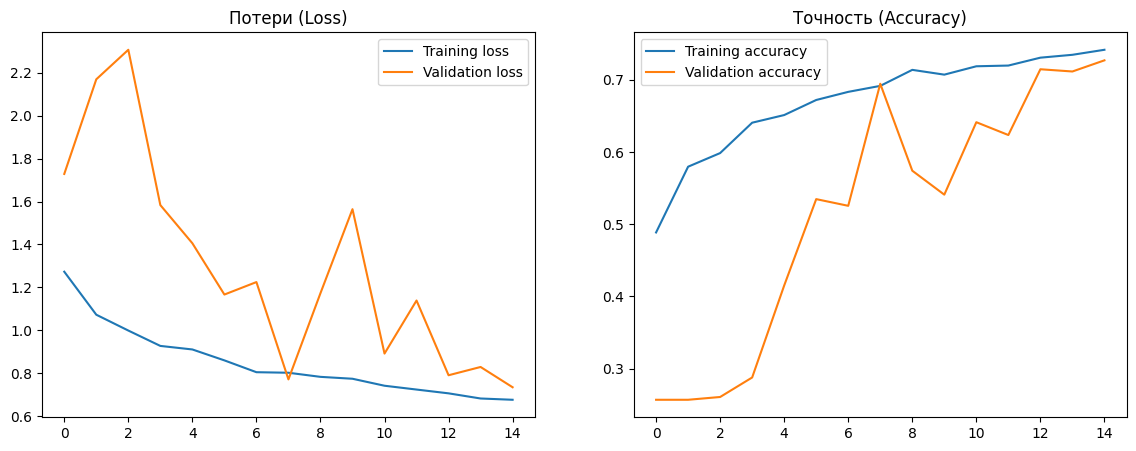

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step
Отчет по классификации:
              precision    recall  f1-score   support

       daisy       0.66      0.81      0.73       244
   dandelion       0.88      0.71      0.79       333
        rose       0.69      0.52      0.59       234
   sunflower       0.78      0.79      0.79       203
       tulip       0.65      0.79      0.71       282

    accuracy                           0.73      1296
   macro avg       0.73      0.73      0.72      1296
weighted avg       0.74      0.73      0.73      1296



In [109]:
# Визуализация обучения
def plot_training_history(history):
    plt.figure(figsize=(14,5))
    
    # Потери
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.title('Потери (Loss)')
    
    # Точность
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.legend()
    plt.title('Точность (Accuracy)')
    
    plt.show()

plot_training_history(history)

# Оценка модели
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Отчет по метрикам
print("Отчет по классификации:")
print(classification_report(y_true, y_pred, target_names=class_labels))

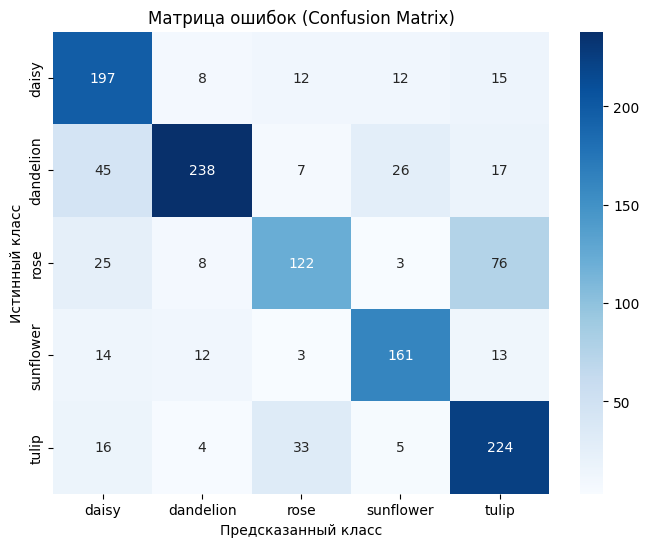

In [111]:
# Матрица ошибок и heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.show()

In [113]:
model.save(os.path.join(MODEL_DIR, 'final_model.h5'))